# EDA Datario
Ao invés de começar por diversas queries diretamente dentro do GCP, decidi explorar os dados primeiramente através do Pandas, visando definir todas as variáveis/features necessárias para responder todas as questões do desafio e também ter insights sobre possíveis análises extras.
<br>Objetivos principais:
- criar arquivos de leitura para não consumir dados do GCP a cada vez que o código for rodado(.csv/.parquet etc...)
- ter uma visão geral de cada dataset
- Decidir quais colunas são necessárias para a soluções de **Todas** as questões do desafio
- Explorar a possibilidade de análises extras relevantes para os dashboards PowerBI e Streamlit.

## Perguntas SQL

## Localização de chamados do 1746
#### Utilize a tabela de Chamados do 1746 e a tabela de Bairros do Rio de Janeiro para as perguntas de 1-5.

1. Quantos chamados foram abertos no dia 01/04/2023?
2. Qual o tipo de chamado que teve mais teve chamados abertos no dia 01/04/2023?
3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?
4. Qual o nome da subprefeitura com mais chamados abertos nesse dia?
5. Existe algum chamado aberto nesse dia que não foi associado a um bairro ou subprefeitura na tabela de bairros? Se sim, por que isso acontece?


## Chamados do 1746 em grandes eventos
#### Utilize a tabela de Chamados do 1746 e a tabela de Ocupação Hoteleira em Grandes Eventos no Rio para as perguntas de 6-10. Para todas as perguntas considere o subtipo de chamado "Perturbação do sossego".

6. Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluindo extremidades)?
7. Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos (Reveillon, Carnaval e Rock in Rio).
8. Quantos chamados desse subtipo foram abertos em cada evento?
9. Qual evento teve a maior média diária de chamados abertos desse subtipo?
10. Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 até 31/12/2023.

##### Importante: a tabela de Chamados do 1746 possui mais de 10M de linhas. Evite fazer consultas exploratórias na tabela sem um filtro ou limite de linhas para economizar sua cota no BigQuery!

## Imports

In [1]:
import basedosdados as bd
import pandas as pd
import plotly.express as px
from datetime import timedelta
from utils.utils import Weather   

In [2]:
# Config
wrio = Weather(-22.5423, -43.1021) # Cria instância da classe Weather com as coordenadas da cidade do Rio de Janeiro

Fonte da informação da Posição Geográfica: [Site Oficial da Prefeitura do Rio de Janeiro](https://www.rio.rj.gov.br/web/guest/exibeconteudo?article-id=87129#:~:text=A%20cidade%20do%20Rio%20de%20Janeiro%20est%C3%A1%20situada%20a%2022%C2%BA54,da%20Regi%C3%A3o%20Sudeste%20do%20Brasil.)

## Datasets
Conforme primeiras observações feitas no notebook 'api_first_test.ipynb'. Vamos começar a analisar as tabelas do BigQuery em ordem da menor tabela para a maior.
<br>
1. datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos
2. datario.dados_mestres.bairro
3. datario.adm_central_atendimento_1746.chamado

### 1. Fluxo de visitantes/Ocupação de eventos 

Os códigos abaixo estão comentados para evitar o consumo desnecessário de dados no GCP

In [2]:
# Rodar a query apenas uma vez e salvar o dataframe como csv

#query_ocup = "SELECT * FROM datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos"
#ocup = bd.read_sql(query_ocup, billing_project_id="dados-rio-433111")
#ocup.to_csv('datasets/ocupacao.csv', index=False)

Downloading: 100%|██████████|


In [3]:
# Dataset Ocupação Original
ocup = pd.read_csv('datasets/ocupacao.csv')
ocup

ano data_inicial  data_final       evento  \
0         02/09 a 04/09 de 2022   2022-09-02  2022-09-04  Rock in Rio   
1         08/09 a 11/09 de 2022   2022-09-08  2022-09-11  Rock in Rio   
2         18/02 a 21/02 de 2023   2023-02-18  2023-02-21     Carnaval   
3  30-31/12 e 01/01 (2022-2023)   2022-12-30  2023-01-01    Reveillon   

   taxa_ocupacao  
0         0.8184  
1         0.9451  
2         0.9554  
3         0.9251

Podemos notar que as observações foram feitas dentro do curto período de setembro/2022 até fevereiro/2023.
<br>Todos os eventos aconteceram em pelo menos 3 dias
<br>O Rock in Rio aconteceu por dois finais de semana seguidos, o ultimo tendo um fluxo de visitantes um pouco maior que o primeiro
<br>O evento de maior fluxo foi o Carnaval, provavelmente por conta de ser feriado público e possívelmente ter sido em dias de calor(verificar depois com a api  Open-Meteo Historical Weather)

In [4]:
# Info do dataframe original
ocup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ano            4 non-null      object 
 1   data_inicial   4 non-null      object 
 2   data_final     4 non-null      object 
 3   evento         4 non-null      object 
 4   taxa_ocupacao  4 non-null      float64
dtypes: float64(1), object(4)
memory usage: 292.0+ bytes


**Tratativas**

Após rodar as tratativas abaixo teremos o dataframe anterior com as seguintes colunas adicionadas:
- dia_inicial = Dia da semana em que o evento iniciou
- dia_final = Dia da semana em que o evento terminou
- duracao = quantidade de dias em que o evento ocorreu
- temperatura_data_inicial = Temperatura média do dia em que o evento iniciou, levando em consideração as coordenadas definidas como parâmetro na classe Weather no início deste notebook
- clima_data_inicial = Classificação do clima do dia de inicio do evento de acordo com o código provido pela API e transcrito para o Inglês
- temperatura_data_final = Temperatura média do dia em que o evento terminou, levando em consideração as coordenadas definidas como parâmetro na classe Weather no início deste notebook
- clima_data_final = Classificação do clima do dia de término do evento de acordo com o código provido pela API e transcrito para o Inglês

Caso houver qualquer dúvida em relação ao consumo da API, verificar a classe Weather criada no arquivo "utils.py"

In [5]:
# Converter colunas de datas para datetime
ocup['data_inicial'] = pd.to_datetime(ocup['data_inicial'])
ocup['data_final'] = pd.to_datetime(ocup['data_final'])

# Extrair apenas o ano(s) da coluna ano
ocup['ano'] = ocup['ano'].apply(lambda x: x.split()[-1])

# Criar colunas para o dia da semana de início e fim dos eventos escrita em Português
dias = {
    0: "Segunda-feira",
    1: "Terça-feira",
    2: "Quarta-feira",
    3: "Quinta-feira",
    4: "Sexta-feira",
    5: "Sábado",
    6: "Domingo"
}

# Extrair apenas o dia da semana como integer e transcreve para Português e cria novas colunas para essas informações
ocup['dia_inicial'] = ocup['data_inicial'].apply(lambda x: x.weekday()).map(dias) # Extrai apenas o dia da semana como integer e transcreve para Português
ocup['dia_final'] = ocup['data_final'].apply(lambda x: x.weekday()).map(dias)

# Criar coluna de duração dos eventos(quantidade de dias)
ocup['duracao'] = (ocup['data_final'] - ocup['data_inicial']) + timedelta(days=1) # Aqui o resultado é somado com timedelta(days=1) porque a subtração do datetime não considera o último dia do período, então somamos mais um dia

# Criar colunas para as temperaturas e climas
# Temperatura/clima do dia utilizando o método forecast da classe Weather
# As linhas abaixo rodam o método .forecast() da classe utils.Weather, ele recebe como parâmetro a data de inicio e fim de um período a ser verificado as temperaturas de cada dia desse período
# Neste caso utilizamos a mesma data como inicio e fim do perído, o que retorna um dataframe de apenas uma linha, com as colunas data, clima(código do clima já convertido para Inglês) e a temperatura média
ocup['temperatura_data_inicial'] = ocup['data_inicial'].apply(lambda x: wrio.forecast(x.date(), x.date())['temperatura media'])
ocup['clima_data_inicial'] = ocup['data_inicial'].apply(lambda x: wrio.forecast(x.date(), x.date())['clima'])
ocup['temperatura_data_final'] = ocup['data_final'].apply(lambda x: wrio.forecast(x.date(), x.date())['temperatura media'])
ocup['clima_data_final'] = ocup['data_final'].apply(lambda x: wrio.forecast(x.date(), x.date())['clima'])
ocup

ano data_inicial data_final       evento  taxa_ocupacao  \
0         2022   2022-09-02 2022-09-04  Rock in Rio         0.8184   
1         2022   2022-09-08 2022-09-11  Rock in Rio         0.9451   
2         2023   2023-02-18 2023-02-21     Carnaval         0.9554   
3  (2022-2023)   2022-12-30 2023-01-01    Reveillon         0.9251   

    dia_inicial    dia_final duracao  temperatura_data_inicial  \
0   Sexta-feira      Domingo  3 days                 13.498249   
1  Quinta-feira      Domingo  4 days                 17.360750   
2        Sábado  Terça-feira  4 days                 20.296165   
3   Sexta-feira      Domingo  3 days                 16.925333   

  clima_data_inicial  temperatura_data_final clima_data_final  
0              Sunny               10.544084             Rain  
1       Mainly Sunny               11.767001             Rain  
2               Rain               20.442001       Heavy Rain  
3               Rain               18.367001       Light Rain

**Conclusão**
<br>Apesar de ter sido em época de chuva e temperaturas baixas, o Reveillon teve uma taxa de ocupação mais alta do que no primeiro final de semana do evento Rock in Rio
<br>O carnaval liderou a taxa de ocupação mesmo com chuva e não sendo um dia considerado "Quente" para o cidadão Carioca

**Para análise futura:**
A taxa de ocupação tem alguma correlação com a média de chamados de Perturbação do Sossego nas datas dos eventos?


### 2. Bairros da cidade de Rio de Janeiro

Os códigos abaixo estão comentados para evitar o consumo desnecessário de dados no GCP

In [11]:
# Rodar a query apenas uma vez e salvar o dataframe como csv

#query_bairro = "SELECT * FROM datario.dados_mestres.bairro"
#bairro = bd.read_sql(query_bairro, billing_project_id="dados-rio-433111")
#bairro.to_csv('datasets/bairro.csv', index=False)

Downloading: 100%|██████████|


In [109]:
bairro = pd.read_csv('datasets/bairro.csv')

Colunas do dataset original:
- id_bairro | Código do bairro dado pela prefeitura do Rio de Janeiro.
- nome | Nome do bairro
- id_area_planejamento | Código da área de planejamento onde está localizado a região de planejamento do bairro. Ver atributo nome_regiao_planejamento.
- id_regiao_planejamento | Código da região de planejamento onde está localizado o região administrativa do bairro. Ver atributo REGIAO_ADM.
- nome_regiao_planejamento | Nome da região de planejamento. Deve respeitar o atributo id_regiao_planejamento.
- id_regiao_administrativa | Código da região administrativa onde está locallizado o bairro.
- nome_regiao_administrativa | Nome da região administrativa onde está localizado o bairro. Este atributo deve respeitar o atributo id_regiao_administrativa.
- subprefeitura | Nome da subprefeitura a que pertence o bairro.
- area | Área (m²) do bairro. Tem o mesmo valor do atributo SHAPE.STArea().
- perimetro | Perímetro (m) do bairro.
- geometry_wkt | -
- geometry | Geometria do bairro no banco do ArcGIS.

In [12]:
bairro.head()

id_bairro          nome  id_area_planejamento  id_regiao_planejamento  \
0          2        Gamboa                     1                     1.1   
1          1         Saúde                     1                     1.1   
2          4          Caju                     1                     1.1   
3          3  Santo Cristo                     1                     1.1   
4        161          Lapa                     1                     1.1   

  nome_regiao_planejamento  id_regiao_administrativa  \
0                   Centro                         1   
1                   Centro                         1   
2                   Centro                         1   
3                   Centro                         1   
4                   Centro                         2   

  nome_regiao_administrativa subprefeitura          area     perimetro  \
0                  Portuaria        Centro  1.112903e+06   4612.833630   
1                  Portuaria        Centro  3.638176e+05   2646.220568   
2                  Portuaria        Centro  5.347481e+06  19800.522524   
3                  Portuaria        Centro  1.684721e+06   6743.227885   
4                     Centro        Centro  2.983258e+05   3849.181818   

                                        geometry_wkt  \
0  POLYGON ((-43.18791509600138 -22.8931217212322...   
1  POLYGON ((-43.181151633502964 -22.895430284304...   
2  MULTIPOLYGON (((-43.22522241788469 -22.8746498...   
3  POLYGON ((-43.194498082949806 -22.903378003392...   
4  POLYGON ((-43.18166120770202 -22.9120798224676...   

                                            geometry  
0  POLYGON((-43.1879150960014 -22.8931217212322, ...  
1  POLYGON((-43.181151633503 -22.8954302843042, -...  
2  MULTIPOLYGON(((-43.196711909178 -22.8872495021...  
3  POLYGON((-43.1944980829498 -22.9033780033923, ...  
4  POLYGON((-43.181661207702 -22.9120798224677, -...

In [4]:
bairro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_bairro                   164 non-null    int64  
 1   nome                        164 non-null    object 
 2   id_area_planejamento        164 non-null    int64  
 3   id_regiao_planejamento      164 non-null    float64
 4   nome_regiao_planejamento    164 non-null    object 
 5   id_regiao_administrativa    164 non-null    int64  
 6   nome_regiao_administrativa  164 non-null    object 
 7   subprefeitura               164 non-null    object 
 8   area                        164 non-null    float64
 9   perimetro                   164 non-null    float64
 10  geometry_wkt                164 non-null    object 
 11  geometry                    164 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 15.5+ KB


Podemos observar que o dataset original possui 12 colunas e 164 linhas, não possui nenhum valor ausente e os tipos das Series variam entre integers, floats e strings.
<br>As colunas geometry_wkt e geometry possuem objetos Polygon e Multypoligon que representam uma sequência de pontos coordenados que formam a região de cada bairro.
<br>É possível utilizar estes objetos em conjunto com as bibliotecas Geopandas e Folium para plotar as regiões dos bairros em um gráfico do tipo mapa

**Subprefeituras e quantidade bairros por subprefeitura**

In [13]:
# Quantas subprefeituras únicas:
print(f'Subprefeituras: {bairro['subprefeitura'].nunique()}')
print(bairro['subprefeitura'].value_counts())

Subprefeituras: 9
subprefeitura
Zona Norte         65
Zona Sul           17
Centro             16
Ilhas              16
Zona Oeste         12
Grande Bangu       12
Jacarepaguá        11
Barra da Tijuca     8
Grande Tijuca       7
Name: count, dtype: int64


**Regiões Administrativas e quantidade de bairros por Região Administrativa**

In [14]:
print(f'Regiões Administrativas: {bairro['nome_regiao_administrativa'].nunique()}')
print(bairro['nome_regiao_administrativa'].value_counts())

Regiões Administrativas: 33
nome_regiao_administrativa
Meier                 16
Ilha Do Governador    15
Madureira             13
Jacarepagua           10
Barra Da Tijuca        8
Botafogo               8
Lagoa                  7
Inhauma                6
Iraja                  6
Bangu                  6
Pavuna                 6
Realengo               6
Campo Grande           5
Portuaria              4
Vila Isabel            4
Rio Comprido           4
Ramos                  4
Sao Cristovao          4
Guaratiba              4
Vigario Geral          4
Anchieta               4
Santa Cruz             3
Penha                  3
Tijuca                 3
Copacabana             2
Centro                 2
Jacarezinho            1
Rocinha                1
Santa Tereza           1
Paqueta                1
Complexo Da Mare       1
Complexo Do Alemão     1
Cidade De Deus         1
Name: count, dtype: int64


**Região Planejamento e quantidade de bairros por região de planejamento**

In [36]:
print(f'Regiões Planejamento: {bairro['nome_regiao_planejamento'].nunique()}')
print(bairro['nome_regiao_planejamento'].value_counts())

Regiões Planejamento: 16
nome_regiao_planejamento
Madureira             19
Zona Sul              18
Méier                 17
Centro                16
Ilha do Governador    15
Bangu                 12
Jacarepaguá           11
Pavuna                10
Barra da Tijuca        8
Penha                  7
Tijuca                 7
Inhaúma                7
Ramos                  5
Campo Grande           5
Guaratiba              4
Santa Cruz             3
Name: count, dtype: int64


**Distribuição geral das subprefeituras, regiões de planejamento e administrativa e quantidade de bairros respectivamente**

In [15]:
distribuicao = bairro.groupby(['subprefeitura','nome_regiao_planejamento','nome_regiao_administrativa']).agg({'nome':'count'})
distribuicao

nome
subprefeitura   nome_regiao_planejamento nome_regiao_administrativa      
Barra da Tijuca Barra da Tijuca          Barra Da Tijuca                8
Centro          Centro                   Centro                         2
                                         Portuaria                      4
                                         Rio Comprido                   4
                                         Santa Tereza                   1
                                         Sao Cristovao                  4
                Zona Sul                 Botafogo                       1
Grande Bangu    Bangu                    Bangu                          6
                                         Realengo                       6
Grande Tijuca   Tijuca                   Tijuca                         3
                                         Vila Isabel                    4
Ilhas           Centro                   Paqueta                        1
                Ilha do Governador       Ilha Do Governador            15
Jacarepaguá     Jacarepaguá              Cidade De Deus                 1
                                         Jacarepagua                   10
Zona Norte      Inhaúma                  Complexo Do Alemão             1
                                         Inhauma                        6
                Madureira                Iraja                          6
                                         Madureira                     13
                Méier                    Jacarezinho                    1
                                         Meier                         16
                Pavuna                   Anchieta                       4
                                         Pavuna                         6
                Penha                    Penha                          3
                                         Vigario Geral                  4
                Ramos                    Complexo Da Mare               1
                                         Ramos                          4
Zona Oeste      Campo Grande             Campo Grande                   5
                Guaratiba                Guaratiba                      4
                Santa Cruz               Santa Cruz                     3
Zona Sul        Zona Sul                 Botafogo                       7
                                         Copacabana                     2
                                         Lagoa                          7
                                         Rocinha                        1

#### Distribuição Geográfica e Tamanho:

**Quais são os bairros com as maiores e menores áreas?**


In [6]:
bairro[bairro['area'] == bairro['area'].min()][['nome', 'subprefeitura', 'area']]

nome subprefeitura          area
114  Zumbi         Ilhas  161117.78418

In [7]:
bairro[bairro['area'] == bairro['area'].max()][['nome', 'subprefeitura', 'area']]

nome subprefeitura          area
162  Guaratiba    Zona Oeste  1.317866e+08

**Como as áreas dos bairros estão distribuídas? Existe uma correlação entre área e perímetro?**

In [29]:
fig = px.strip(bairro,y="area", hover_data=['nome', 'area','subprefeitura', 'nome_regiao_administrativa'])#, color='subprefeitura')
fig.show()

A maior parte dos bairros tem a área abaixo de 20M²

In [20]:
fig = px.histogram(bairro, x='nome', y='area', title="Área de cada bairro", color='subprefeitura')
fig.show()

In [25]:
ar_per = bairro[['area','perimetro']].corr()
ar_per

area  perimetro
area       1.000000   0.920674
perimetro  0.920674   1.000000

**Qual é a distribuição dos bairros entre as diferentes regiões administrativas?**

In [22]:
qt_bairroRegiao = bairro.groupby('nome_regiao_administrativa').agg({'nome':'count'}).reset_index()

fig = px.histogram(qt_bairroRegiao, x='nome_regiao_administrativa', y='nome', title='Bairros por Região Administrativa')
fig.show()



In [44]:
qt_bairroSubprefeitura = bairro.groupby('subprefeitura').agg({'nome':'count'}).reset_index()

fig = px.histogram(qt_bairroSubprefeitura, x='subprefeitura', y='nome', title='Bairros por Subprefeitura')
fig.show()


In [43]:
qt_bairroPlanejamento = bairro.groupby('nome_regiao_planejamento').agg({'nome':'count'}).reset_index()

fig = px.histogram(qt_bairroPlanejamento, x='nome_regiao_planejamento', y='nome', title='Bairros por Região de Planejamento')
fig.show()


**Plots Geográficos com Geopandas**

In [23]:
bairro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_bairro                   164 non-null    int64  
 1   nome                        164 non-null    object 
 2   id_area_planejamento        164 non-null    int64  
 3   id_regiao_planejamento      164 non-null    float64
 4   nome_regiao_planejamento    164 non-null    object 
 5   id_regiao_administrativa    164 non-null    int64  
 6   nome_regiao_administrativa  164 non-null    object 
 7   subprefeitura               164 non-null    object 
 8   area                        164 non-null    float64
 9   perimetro                   164 non-null    float64
 10  geometry_wkt                164 non-null    object 
 11  geometry                    164 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 15.5+ KB


In [110]:
import geopandas
from shapely import wkt
import matplotlib.pyplot as plt
import folium
gdf = geopandas.GeoDataFrame(bairro)#, geometry=bairro['geometry'], crs=4326)
gdf['geometry'] = gdf['geometry_wkt'].apply(wkt.loads)
gdf = gdf.set_geometry('geometry')

In [31]:
popup_content = ['nome', 'subprefeitura', 'area']
map = folium.Map(location=[-22.8831165538581, -43.42882206268638], tiles="OpenStreetMap", zoom_start=11)
gdf.explore(tiles="CartoDB positron", popup=popup_content, tooltip=popup_content, column='subprefeitura', legend=False, figsize=(5,5),
            edgecolor='k', m=map)


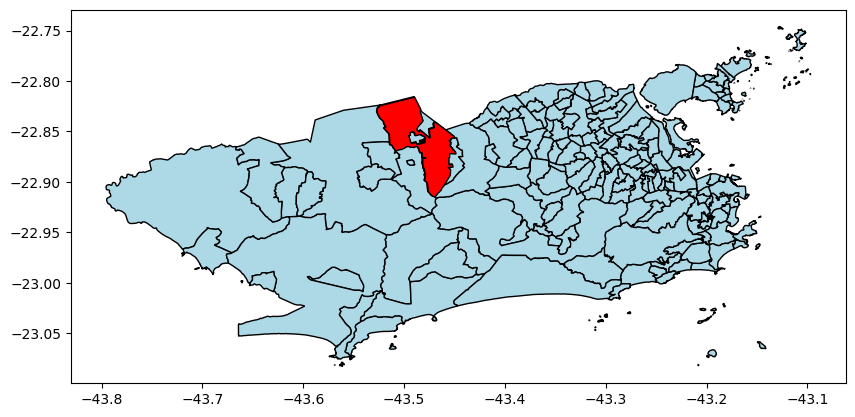

In [33]:
# Filtra o GeoDataFrame para isolar o bairro escolhido
bairro_destaque = gdf[gdf['nome'] == 'Bangu']

# Plota o mapa com todos os bairros
ax = gdf.plot(edgecolor='black', facecolor='lightblue', figsize=(10, 10))

# Destaca bairro específico
bairro_destaque.plot(ax=ax, edgecolor='black', facecolor='red')  # Cor de destaque em vermelho

plt.show()

### 3. Chamados

**datario.adm_central_atendimento_1746.chamado**
<br>Aqui vamos analisar cuidadosamente os atributos do dataset antes de fazer qualquer query dentro do PCD para evitar o consumo desnecessário de dados.
<br> Objetivos:

- Explorar e entender os atributos do dataset e como se relacionam com os outros datasets e apis vistos até o presente momento.
- Verificar quais são os atributos necessários para a solução de todas as questões do desafio para possibilitar o planejamento de queries mais performáticas.
- Identificar se há mais atributos relevantes para análises extras com o objetivo de enriquecer a interatividade dos dashboards que serão desenvolvidos futuramente.
- Fazer uma primeira query geral e , otimizada para gerar um arquivo csv que será usado para análises tanto no python quanto nos dashboards a serem desenvolvidos.
- Planejar as queries antes da resolução das questões do arquivo "perguntas_sql.md"

#### Analisando as colunas

- **id_chamado | Identificador único do chamado no banco de dados.**
- id_origem_ocorrencia | -
- **data_inicio	| Data de abertura do chamado. Ocorre quando o operador registra o chamado.**
- data_fim | Data de fechamento do chamado. O chamado é fechado quando o pedido é atendido ou quando se percebe que o pedido não pode ser atendido.
- **id_bairro | Identificador único, no banco de dados, do bairro onde ocorreu o fato que gerou o chamado.**
- id_territorialidade	| Identificador único, no banco de dados, da territorialidade onde ocorreu o fato que gerou o chamado. Territorialidade é uma região da cidade do Rio de Janeiro que tem com responsável um órgão especifico. Exemplo: CDURP, que é responsável pela região do porto do Rio de Janeiro.
- id_logradouro | Identificador único, no banco de dados, do logradouro onde ocorreu o fato que gerou o chamado.
- numero_logradouro | Número da porta onde ocorreu o fato que gerou o chamado.
- id_unidade_organizacional | Identificador único, no banco de dados, do órgão que executa o chamado. Por exemplo: identificador da COMLURB quando o chamado é relativo a limpeza urbana.
- **nome_unidade_organizacional | Nome do órgão que executa a demanda. Por exemplo: COMLURB quando a demanda é relativa a limpeza urbana.**
- id_unidade_organizacional_mae | ID da unidade organizacional mãe do orgão que executa a demanda. Por exemplo: "CVA - Coordenação de Vigilância de Alimentos" é quem executa a demanda e obede a unidade organizacional mãe "IVISA-RIO - Instituto Municipal de Vigilância Sanitária, de Zoonoses e de Inspeção Agropecuária". A coluna se refere ao ID deste último.
- unidade_organizacional_ouvidoria | -
- **categoria | Categoria do chamado. Exemplo: Serviço, informação, sugestão, elogio, reclamação, crítica.**
- id_tipo | Identificador único, no banco de dados, do tipo do chamado. Ex: Iluminação pública.
- **tipo | Nome do tipo do chamado. Ex: Iluminação pública.**
- id_subtipo - Identificador único, no banco de dados, do subtipo do chamado. Ex: Reparo de lâmpada apagada.
- **subtipo | Nome do subtipo do chamado. Ex: Reparo de lâmpada apagada.**
- **status | Status do chamado. Ex. Fechado com solução, aberto em andamento, pendente etc.**
- **longitude | Longitude do lugar do evento que motivou o chamado.**
- **latitude	| Latitude do lugar do evento que motivou o chamado.**
- data_alvo_finalizacao | Data prevista para o atendimento do chamado. Caso prazo_tipo seja D fica em branco até o diagnóstico ser feito.
- data_alvo_diagnostico | Data prevista para fazer o diagnóstico do serviço. Caso prazo_tipo seja F esta data fica em branco.
- data_real_diagnostico | Data em que foi feito o diagnóstico do serviço. Caso prazo_tipo seja F esta data fica em branco.
- tempo_prazo | Prazo para o serviço ser feito. Em dias ou horas após a abertura do chamado. Caso haja diagnóstico o prazo conta após se fazer o diagnóstico.
- prazo_unidade | Unidade de tempo utilizada no prazo. Dias ou horas. D ou H.
- prazo_tipo | Diagnóstico ou finalização. D ou F. Indica se a chamada precisa de diagnóstico ou não. Alguns serviços precisam de avaliação para serem feitos, neste caso é feito o diagnóstico. Por exemplo, pode de árvore. Há a necessidade de um engenheiro ambiental verificar a necessidade da poda ou não.
- dentro_prazo | Indica se a data alvo de finalização do chamado ainda está dentro do prazo estipulado.
- **situacao | Identifica se o chamado foi encerrado**
- **tipo_situacao |Indica o status atual do chamado entre as categorias Atendido, Atendido parcialmente, Não atendido, Não constatado e Andamento**
- justificativa_status | Justificativa que os órgãos usam ao definir o status. Exemplo: SEM POSSIBILIDADE DE ATENDIMENTO - justificativa: Fora de área de atuação do municipio
- **reclamacoes | Quantidade de reclamações.**
- data_particao	| -	

#### Perguntas
**Espaço para definir as colunas necessárias para responder as perguntas do desafio**
<br>Ao longo desta análise vou destacar as **colunas escolhidas em negrito** na célula markdown anterior.
1. Quantos chamados foram abertos no dia 01/04/2023?
2. Qual o tipo de chamado que mais teve chamados abertos no dia 01/04/2023?
3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?
4. Qual o nome da subprefeitura com mais chamados abertos nesse dia?
5. Existe algum chamado aberto nesse dia que não foi associado a um bairro ou subprefeitura na tabela de bairros? Se sim, por que isso acontece?
6. Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluindo extremidades)?
7. Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos (Reveillon, Carnaval e Rock in Rio).
8. Quantos chamados desse subtipo foram abertos em cada evento?
9. Qual evento teve a maior média diária de chamados abertos desse subtipo?
10. Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 até 31/12/2023.

**ATENÇÃO** 
<br>As perguntas listadas acima não serão respondidas neste notebook.
<br>O objetivo deste notebook é explorar e entender os dados a fim de ajudar no planejamento da resolução das questões e gerar insights para análises extras.

**Decisão**
<br>Após analisar a relação dataset de chamados/perguntas e os outros datasets, a decisão foi de manter as seguintes colunas:
- id_chamado
- data_inicio
- id_bairro
- nome_unidade_organizacional
- categoria
- tipo
- subtipo
- status
- longitude
- latitude
- situacao
- tipo_situacao
- reclamacoes
<br>13 colunas escolhidas de 32 do dataset original
<br>O período será de 01/01/2022 até 31/12/2023

Uma consulta total do dataset geraria um consumo de: **3,6 GB** quando executada.
<br>"SELECT
<br>  *
<br>FROM datario.adm_central_atendimento_1746.chamado"

Selecionando estas colunas podemos reduzir o consumo para: **2,2 BG** quando executada.
<br>"SELECT
<br>    id_chamado,
<br>    data_inicio,
<br>    id_bairro,
<br>    nome_unidade_organizacional,
<br>    categoria,
<br>    tipo,
<br>    subtipo,
<br>    status,
<br>    longitude,
<br>    latitude,
<br>    situacao,
<br>    tipo_situacao,
<br>    reclamacoes
<br>FROM datario.adm_central_atendimento_1746.chamado"
<br>WHERE data_inicio >= '2022-01-01T00:00:00' AND data_inicio < '2024-01-01T00:00:00'

In [4]:
# Rodar a query apenas uma vez e salvar o dataframe como csv
# CONSUMO ALTO NO GCP
# TEMPO DE EXECUÇÃO ESTIMADO: 6 minutos
query_chamado = """SELECT
                        id_chamado,
                        data_inicio,
                        id_bairro,
                        nome_unidade_organizacional,
                        categoria,
                        tipo,
                        subtipo,
                        status,
                        longitude,
                        latitude,
                        situacao,
                        tipo_situacao,
                        reclamacoes  
                    FROM datario.adm_central_atendimento_1746.chamado
                    WHERE data_inicio >= '2022-01-01T00:00:00' AND data_inicio < '2024-01-01T00:00:00'
"""
chamado = bd.read_sql(query_chamado, billing_project_id="dados-rio-433111")
chamado.to_parquet('chamado.parquet', index=False)

Downloading: 100%|██████████|


In [16]:
chamado = pd.read_csv('datasets/chamado.csv')
chamado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634336 entries, 0 to 1634335
Data columns (total 13 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   id_chamado                   1634336 non-null  int64  
 1   data_inicio                  1634336 non-null  object 
 2   id_bairro                    1562182 non-null  float64
 3   nome_unidade_organizacional  1634336 non-null  object 
 4   categoria                    1634336 non-null  object 
 5   tipo                         1634336 non-null  object 
 6   subtipo                      1634336 non-null  object 
 7   status                       1634336 non-null  object 
 8   longitude                    1192576 non-null  float64
 9   latitude                     1192576 non-null  float64
 10  situacao                     1634336 non-null  object 
 11  tipo_situacao                1634336 non-null  object 
 12  reclamacoes                  1634336 non-n

Dataset original:
- 11.205.978 linhas (Consulta:22/08/2024 às 17h)
- 32 colunas
- 3,6 GB de consumo no GCP

CSV:    
- 1.634.336 linhas
- 13 colunas
- 162,1 MB de consumo de memória ram local
- 345,9 MB de armazenamento local

Não é possível fazer upload de um arquivo csv deste tamanho no github, então vamos converter o formato de csv para parquet para que o arquivo seja comprimido em um formato menor

In [17]:
#chamado.to_parquet('chamado.parquet', engine='pyarrow', compression='snappy')

A partir daqui usaremos apenas o arquivo "chamado.parquet" e o arquivo gerado pelos códigos comentados acima será deletado.
<br>Parquet:
- 1.634.336 linhas
- 13 colunas
- 162,1 MB de consumo aproximado de memória ram local
- 34 MB de armazenamento local

In [35]:
chamado = pd.read_parquet('datasets/chamado.parquet')
chamado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634336 entries, 0 to 1634335
Data columns (total 13 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   id_chamado                   1634336 non-null  object        
 1   data_inicio                  1634336 non-null  datetime64[us]
 2   id_bairro                    1562182 non-null  object        
 3   nome_unidade_organizacional  1634336 non-null  object        
 4   categoria                    1634336 non-null  object        
 5   tipo                         1634336 non-null  object        
 6   subtipo                      1634336 non-null  object        
 7   status                       1634336 non-null  object        
 8   longitude                    1192576 non-null  float64       
 9   latitude                     1192576 non-null  float64       
 10  situacao                     1634336 non-null  object        
 11  tipo_situac

Como primeira observação é importante notar que há alguns valores ausentes na coluna id_bairro, coluna que é chave para relacionar com a tabela "bairro"
<br> Existe também uma quantidade significativa de valores ausentes nas colunas longitude e latitude, porém esta é uma coluna que não é necessária para a solução das questões do desafio. Foi uma das colunas escolhidas para possíveis análises extras.

In [36]:
chamado.head()

id_chamado         data_inicio id_bairro  \
0   17724465 2022-09-22 09:29:37         7   
1   17692886 2022-09-13 14:58:04        20   
2   17678260 2022-09-08 19:57:06        45   
3   17663453 2022-09-03 22:22:12        46   
4   17713546 2022-09-19 19:27:01        47   

                         nome_unidade_organizacional categoria  \
0  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
1  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
2  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
3  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
4  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   

                 tipo                    subtipo               status  \
0  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
1  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
2  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
3  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
4  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   

   longitude   latitude   situacao tipo_situacao  reclamacoes  
0 -43.208500 -22.930077  Encerrado      Atendido            0  
1 -43.186785 -22.943203  Encerrado      Atendido            0  
2 -43.282525 -22.825823  Encerrado      Atendido            0  
3 -43.298253 -22.821174  Encerrado      Atendido            0  
4 -43.312394 -22.823038  Encerrado      Atendido            0

**Quantidade de valores distintos dentre as variáveis categóricas**

In [66]:
# Quantidade de valores distintos de algumas colunas
print(f'''Quantidade de bairros: {chamado['id_bairro'].nunique()}
Quantidade de Unidades organizacionais: {chamado['nome_unidade_organizacional'].nunique()}
Quantidade de categorias: {chamado['categoria'].nunique()}
Quantidade de tipos: {chamado['tipo'].nunique()}
Quantidade de subtipos: {chamado['subtipo'].nunique()}
Quantidade de status: {chamado['status'].nunique()}
Quantidade de situações: {chamado['situacao'].nunique()}
Quantidade de tipos de situações: {chamado['tipo_situacao'].nunique()}''')

Quantidade de bairros: 164
Quantidade de Unidades organizacionais: 355
Quantidade de categorias: 1
Quantidade de tipos: 107
Quantidade de subtipos: 522
Quantidade de status: 10
Quantidade de situações: 2
Quantidade de tipos de situações: 5


**Quais as 10 unidades organizacionais com maior incidência?**

In [72]:

chamado['nome_unidade_organizacional'].value_counts().head(10)

nome_unidade_organizacional
COMLURB - Companhia Municipal de Limpeza Urbana                 469272
GM-RIO - Guarda Municipal do Rio de Janeiro                     316433
RIOLUZ - Companhia Municipal de Energia e Iluminação            219660
TR/SUBTT/CGLF/CFV - Coordenadoria de Fiscalização e Vistoria     97328
GMA - Gerência de Manutenção Semafórica                          39892
21aGC                                                            34708
DEFESA CIVIL - Subsecretaria de Proteção e Defesa Civil          30131
CLF - Coordenadoria de Licenciamento e Fiscalização              28308
13aGC                                                            17604
22aGC                                                            17093
Name: count, dtype: int64

**Quais os 10 tipos de chamados com maior incidência?**

In [71]:
chamado['tipo'].value_counts().head(10)

tipo
Estacionamento irregular            247610
Remoção Gratuita                    204845
Iluminação Pública                  161406
Pavimentação                        120699
Limpeza de logradouros              109807
Ônibus                               97688
Drenagem e Saneamento                84790
Manejo Arbóreo                       76205
Manutenção de iluminação pública     58253
Perturbação do sossego               46857
Name: count, dtype: int64

**Quais os 10 subtipos com maior incidência?**

In [73]:
chamado['subtipo'].value_counts().head(10)

subtipo
Fiscalização de estacionamento irregular de veículo            247614
Remoção de entulho e bens inservíveis                          199814
Reparo de lâmpada apagada                                      111132
Reparo de buraco, deformação ou afundamento na pista           105664
Verificação de ar condicionado inoperante no ônibus             63692
Reparo de Luminária                                             58253
Poda de árvore em logradouro                                    52066
Manutenção/Desobstrução de ramais de águas pluviais e ralos     46513
Remoção de resíduos no logradouro                               44380
Perturbação do sossego                                          42830
Name: count, dtype: int64

**Quais  são as 10 unidades organizacionais com mais reclamações?**

In [78]:
chamado.groupby('nome_unidade_organizacional').agg({'reclamacoes':'sum'}).sort_values('reclamacoes', ascending=False).head(10)

reclamacoes
nome_unidade_organizacional                                    
RIOLUZ - Companhia Municipal de Energia e Ilumi...        23616
COMLURB - Companhia Municipal de Limpeza Urbana           22287
GM-RIO - Guarda Municipal do Rio de Janeiro               14452
21aGC                                                      3670
CLF - Coordenadoria de Licenciamento e Fiscaliz...         1638
GMA - Gerência de Manutenção Semafórica                    1578
DEFESA CIVIL - Subsecretaria de Proteção e Defe...         1440
TR/SUBTT/CGLF/CFV - Coordenadoria de Fiscalizaç...         1259
SMPDA - Secretaria Municipal de Proteção e Defe...         1177
22aGC                                                      1087

In [113]:
bairro['id_bairro'] = bairro['id_bairro'].apply(lambda x: str(x))
df_merged = pd.merge(chamado, bairro, how='left', on='id_bairro')

In [114]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634336 entries, 0 to 1634335
Data columns (total 24 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   id_chamado                   1634336 non-null  object        
 1   data_inicio                  1634336 non-null  datetime64[us]
 2   id_bairro                    1562182 non-null  object        
 3   nome_unidade_organizacional  1634336 non-null  object        
 4   categoria                    1634336 non-null  object        
 5   tipo                         1634336 non-null  object        
 6   subtipo                      1634336 non-null  object        
 7   status                       1634336 non-null  object        
 8   longitude                    1192576 non-null  float64       
 9   latitude                     1192576 non-null  float64       
 10  situacao                     1634336 non-null  object        
 11  tipo_situac

In [115]:
df_merged.head()

id_chamado         data_inicio id_bairro  \
0   17724465 2022-09-22 09:29:37         7   
1   17692886 2022-09-13 14:58:04        20   
2   17678260 2022-09-08 19:57:06        45   
3   17663453 2022-09-03 22:22:12        46   
4   17713546 2022-09-19 19:27:01        47   

                         nome_unidade_organizacional categoria  \
0  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
1  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
2  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
3  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   
4  RIOLUZ - Companhia Municipal de Energia e Ilum...   Serviço   

                 tipo                    subtipo               status  \
0  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
1  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
2  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
3  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   
4  Iluminação Pública  Reparo de lâmpada apagada  Fechado com solução   

   longitude   latitude  ... id_area_planejamento id_regiao_planejamento  \
0 -43.208500 -22.930077  ...                  1.0                    1.1   
1 -43.186785 -22.943203  ...                  2.0                    2.1   
2 -43.282525 -22.825823  ...                  3.0                    3.5   
3 -43.298253 -22.821174  ...                  3.0                    3.5   
4 -43.312394 -22.823038  ...                  3.0                    3.5   

   nome_regiao_planejamento id_regiao_administrativa  \
0                    Centro                      3.0   
1                  Zona Sul                      4.0   
2                     Penha                     11.0   
3                     Penha                     31.0   
4                     Penha                     31.0   

   nome_regiao_administrativa  subprefeitura          area     perimetro  \
0                Rio Comprido         Centro  3.342511e+06  12681.079258   
1                    Botafogo       Zona Sul  4.798956e+06  12136.391939   
2                       Penha     Zona Norte  3.522222e+06  12591.627245   
3               Vigario Geral     Zona Norte  3.856801e+06  13947.722741   
4               Vigario Geral     Zona Norte  2.197969e+06   9216.714275   

                                        geometry_wkt  \
0  POLYGON ((-43.21012221062528 -22.9158323591650...   
1  POLYGON ((-43.17831346247171 -22.9400579120343...   
2  POLYGON ((-43.303332877961225 -22.839230704414...   
3  MULTIPOLYGON (((-43.2723675263724 -22.80354756...   
4  POLYGON ((-43.28839865412204 -22.8104272239593...   

                                            geometry  
0  POLYGON((-43.2101222106253 -22.9158323591651, ...  
1  POLYGON((-43.1783134624717 -22.9400579120344, ...  
2  POLYGON((-43.3033328779612 -22.839230704415, -...  
3  MULTIPOLYGON(((-43.2713448281311 -22.807185461...  
4  POLYGON((-43.288398654122 -22.8104272239593, -...  

[5 rows x 24 columns]

In [131]:
bairros_com_id = df_merged[~df_merged['nome'].isnull()]
bairros_sem_id = df_merged[df_merged['nome'].isnull()]

In [133]:
bairros_com_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1562182 entries, 0 to 1634335
Data columns (total 24 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   id_chamado                   1562182 non-null  object        
 1   data_inicio                  1562182 non-null  datetime64[us]
 2   id_bairro                    1562182 non-null  object        
 3   nome_unidade_organizacional  1562182 non-null  object        
 4   categoria                    1562182 non-null  object        
 5   tipo                         1562182 non-null  object        
 6   subtipo                      1562182 non-null  object        
 7   status                       1562182 non-null  object        
 8   longitude                    1192576 non-null  float64       
 9   latitude                     1192576 non-null  float64       
 10  situacao                     1562182 non-null  object        
 11  tipo_situacao   

In [135]:
bairros_sem_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72154 entries, 1902 to 1633896
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id_chamado                   72154 non-null  object        
 1   data_inicio                  72154 non-null  datetime64[us]
 2   id_bairro                    0 non-null      object        
 3   nome_unidade_organizacional  72154 non-null  object        
 4   categoria                    72154 non-null  object        
 5   tipo                         72154 non-null  object        
 6   subtipo                      72154 non-null  object        
 7   status                       72154 non-null  object        
 8   longitude                    0 non-null      float64       
 9   latitude                     0 non-null      float64       
 10  situacao                     72154 non-null  object        
 11  tipo_situacao                72154 non-nu

Há 72.154 chamados sem informações sobre o bairro

**Quantidade de chamados por subprefeitura**

In [132]:
bairros_com_id.groupby('subprefeitura').agg({'id_chamado':'count'}).sort_values('id_chamado', ascending=False)

id_chamado
subprefeitura              
Zona Norte           459297
Zona Oeste           268993
Zona Sul             184904
Jacarepaguá          147463
Grande Tijuca        124330
Grande Bangu         121821
Centro               105333
Barra da Tijuca       99475
Ilhas                 50566

In [ ]:
# Gerar arquivo sqlite com as tabelas
import pandas as pd
import sqlite3

# Passo 1: Leia o arquivo Parquet em um DataFrame
df = pd.read_parquet('datasets/chamado.parquet')
bairro = pd.read_csv('datasets/bairro.csv')
ocup = pd.read_csv('datasets/ocupacao.csv')
# Passo 2: Conecte ao banco de dados SQLite (ou crie um novo)
con = sqlite3.connect('datasets/arquivo.db')

# Passo 3: Escreva o DataFrame no SQLite como uma nova tabela
#df.to_sql('chamado', con, if_exists='replace', index=False)
#bairro.to_sql('bairro', con, if_exists='replace', index=False)
#ocup.to_sql('ocupacao', con, if_exists='replace', index=False)

# Feche a conexão
con.close()
